# **Crop and Weed Detection using YOLOv8**

This project applies **YOLOv8** for object detection to distinguish between **crops** and **weeds**.  
The goal is to support **precision agriculture** by enabling automatic weed detection, which can help reduce manual labor and optimize crop yield.  

The workflow includes:  
1. 📂 Dataset Preparation  
2. 🏋️ Training YOLOv8 Model  
3. ✅ Validation  
4. 🔎 Prediction / Inference  
5. 📊 Evaluation & Metrics

# Environment Setup

In [14]:
from google.colab import drive
drive.mount('/content/drive')

!pip install albumentations

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!pip install ultralytics

# Imports

In [16]:
import os
import zipfile
import random
import shutil
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import albumentations as A
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [17]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

True
1
Tesla T4


# 📂 Dataset Preparation
In this section, we prepare the dataset for YOLOv8 training:  
- Unzip and organize raw files.  
- Apply **data augmentation** (flips, rotations, brightness/contrast adjustments) using **Albumentations**.  
- Split the dataset into **train/validation/test sets**.  
- Convert annotations into **YOLO format** (text files with class + bounding box coordinates).  


In [26]:
zip_path = "/content/drive/MyDrive/Project5_Ag_Crop and weed detection.zip"
base_dir = "/content/crop_weed_dataset"

images_dir = os.path.join(base_dir, "images")
labels_dir = os.path.join(base_dir, "labels")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(base_dir)


In [27]:
base_dir =  "/content/crop_weed_dataset"
for root, dirs, files in os.walk(base_dir):
    for f in files[:20]:
        print(os.path.join(root, f))


/content/crop_weed_dataset/data.yaml
/content/crop_weed_dataset/Project5_Ag_Crop and weed detection/Project5_Ag_Crop and weed detection.zip
/content/crop_weed_dataset/Project5_Ag_Crop and weed detection/~$oject1.docx
/content/crop_weed_dataset/Project5_Ag_Crop and weed detection/Project5_Ag_Crop and weed detection.docx


In [28]:
inner_zip_path = "/content/crop_weed_dataset/Project5_Ag_Crop and weed detection/Project5_Ag_Crop and weed detection.zip"
extract_path = "/content/crop_weed_dataset/final_data"

# Unzip the inner ZIP
with zipfile.ZipFile(inner_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ Inner ZIP extracted to {extract_path}")

# Check structure
for root, dirs, files in os.walk(extract_path):
    print(root, len(files))


✅ Inner ZIP extracted to /content/crop_weed_dataset/final_data
/content/crop_weed_dataset/final_data 1
/content/crop_weed_dataset/final_data/agri_data 0
/content/crop_weed_dataset/final_data/agri_data/data 2600


In [29]:
zip_path = "/content/drive/MyDrive/Project5_Ag_Crop and weed detection.zip"
base_dir = "/content/crop_weed_dataset"

images_dir = os.path.join(base_dir, "images")
labels_dir = os.path.join(base_dir, "labels")

all_images, all_labels = [], []
for root, _, files in os.walk(base_dir):
    for f in files:
        if f.endswith(('.jpg', '.jpeg', '.png')):
            all_images.append(os.path.join(root, f))
        elif f.endswith('.txt'):
            all_labels.append(os.path.join(root, f))

print(f"Found {len(all_images)} images and {len(all_labels)} labels.")

#  Prepare YOLO structure
for subfolder in ['train', 'val']:
    os.makedirs(os.path.join(images_dir, subfolder), exist_ok=True)
    os.makedirs(os.path.join(labels_dir, subfolder), exist_ok=True)

# Define augmentation pipeline
augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=30, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.3)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))


def read_labels(label_path):
    bboxes, classes = [], []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            classes.append(parts[0])
            bboxes.append([float(x) for x in parts[1:]])
    return bboxes, classes


def save_augmented(image, bboxes, classes, img_path, lbl_path):
    Image.fromarray(image).save(img_path)
    with open(lbl_path, 'w') as f:
        for cls, box in zip(classes, bboxes):
            f.write(f"{cls} {' '.join(map(str, box))}\n")

# Process, resize, augment
processed_images = []
for img_path in tqdm(all_images, desc="Processing images"):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((512, 512))
    img.save(img_path)


    lbl_path = os.path.splitext(img_path)[0] + ".txt"
    if not os.path.exists(lbl_path):
        continue

    processed_images.append((img_path, lbl_path))


    bboxes, classes = read_labels(lbl_path)
    img_cv = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    for i in range(2):
        augmented = augmentor(image=img_cv, bboxes=bboxes, class_labels=classes)
        aug_img = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_classes = augmented['class_labels']

        new_img_name = f"{os.path.splitext(os.path.basename(img_path))[0]}_aug{i}.jpg"
        new_lbl_name = f"{os.path.splitext(os.path.basename(lbl_path))[0]}_aug{i}.txt"

        save_augmented(
            aug_img, aug_bboxes, aug_classes,
            os.path.join(base_dir, new_img_name),
            os.path.join(base_dir, new_lbl_name)
        )
        processed_images.append((os.path.join(base_dir, new_img_name),
                                  os.path.join(base_dir, new_lbl_name)))

print(f"✅ Augmentation complete. Total images after augmentation: {len(processed_images)}")

#  Split into train/val
random.shuffle(processed_images)
split_idx = int(0.8 * len(processed_images))
train_data = processed_images[:split_idx]
val_data = processed_images[split_idx:]

def move_data(data_list, split_type):
    for img_path, lbl_path in data_list:
        shutil.move(img_path, os.path.join(images_dir, split_type, os.path.basename(img_path)))
        shutil.move(lbl_path, os.path.join(labels_dir, split_type, os.path.basename(lbl_path)))

move_data(train_data, "train")
move_data(val_data, "val")
print(f"✅ Train/Val split done: {len(train_data)} train, {len(val_data)} val")

# Create data.yaml
yaml_content = f"""
path: {base_dir}
train: images/train
val: images/val

nc: 2
names: ['crop', 'weed']
"""
with open(os.path.join(base_dir, "data.yaml"), "w") as f:
    f.write(yaml_content)

print("✅ Dataset ready for YOLOv8 training!")

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Found 1300 images and 1301 labels.


Processing images: 100%|██████████| 1300/1300 [00:20<00:00, 62.74it/s]


✅ Augmentation complete. Total images after augmentation: 3900
✅ Train/Val split done: 3120 train, 780 val
✅ Dataset ready for YOLOv8 training!


# Dataset Visualization

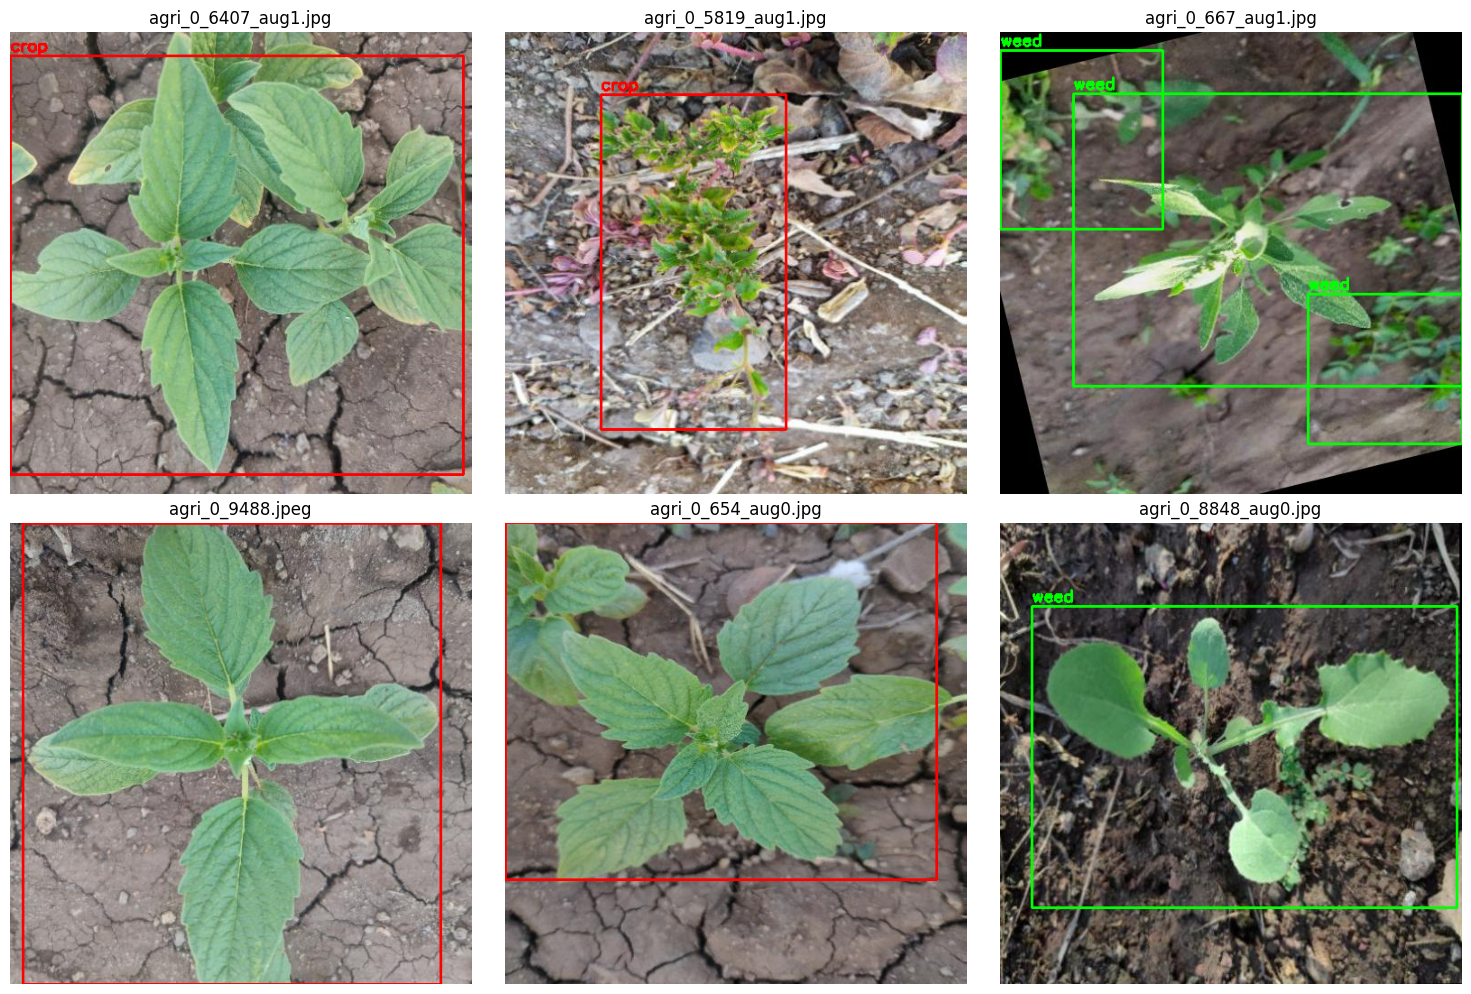

In [30]:
# Paths
train_img_dir = "/content/crop_weed_dataset/images/train"
train_lbl_dir = "/content/crop_weed_dataset/labels/train"

classes = ['crop', 'weed']

# Collect valid images with labels
valid_images = [img for img in os.listdir(train_img_dir)
                if os.path.exists(os.path.join(train_lbl_dir, img.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt')))]

# Pick 6 random samples
samples = random.sample(valid_images, 6)

# Plot
plt.figure(figsize=(15, 10))
for i, sample_img in enumerate(samples):
    img_path = os.path.join(train_img_dir, sample_img)
    lbl_path = os.path.join(train_lbl_dir, sample_img.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt'))

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # Draw YOLO bounding boxes
    with open(lbl_path, 'r') as f:
        for line in f.readlines():
            cls, x, y, bw, bh = map(float, line.strip().split())
            cls = int(cls)
            x1 = int((x - bw/2) * w)
            y1 = int((y - bh/2) * h)
            x2 = int((x + bw/2) * w)
            y2 = int((y + bh/2) * h)
            color = (255, 0, 0) if cls == 0 else (0, 255, 0)
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img, classes[cls], (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Show in grid
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(sample_img)

plt.tight_layout()
plt.show()

# Training YOLOv8 Model
Here, we train the YOLOv8 model:  
- Specify **model configuration** (YOLOv8n, YOLOv8s, etc.).  
- Define **epochs, batch size, and image size**.  
- Training is executed using the **Ultralytics YOLOv8 library**.  
- The model learns to detect **crops vs weeds**.  


In [31]:
from ultralytics import YOLO

# Load YOLOv8 small model
model = YOLO('yolov8n.pt')  # or yolov8s.pt for better accuracy

# Clear Ultralytics cache
!yolo clear cache

# Train
model.train(
    data="/content/crop_weed_dataset/data.yaml",
    epochs=50,
    imgsz=512,
    batch=16,
    name="crop_weed_detector",
    device='gpu'  # set to 'cpu' if no GPU
)

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/cfg/__init__.py", line 907, in entrypoint
    check_dict_alignment(full_args_dict, {a: ""})
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/cfg/__init__.py", line 498, in check_dict_alignment
    raise SyntaxError(string + CLI_HELP_MSG) from e
SyntaxError: 'clear' is not a valid YOLO argument. Similar arguments are i.e. ['shear=0.0', 'scale=0.5'].

    Arguments received: ['yolo', 'clear', 'cache']. Ultralytics 'yolo' commands use the following syntax:

        yolo TASK MODE ARGS

        Where   TASK (optional) is one of ['pose', 'obb', 'detect', 'classify', 'segment']
                MODE (required) is one of ['predict', 'track', 'train', 'benchmark', 'val', 'export']
                ARGS (optional) are any number of custom 'arg=value' pairs like 'imgsz=320' that override defa

train: Scanning /content/crop_weed_dataset/labels/train... 3120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3120/3120 [00:01<00:00, 2197.15it/s]


train: New cache created: /content/crop_weed_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 475.3±208.1 MB/s, size: 58.7 KB)


val: Scanning /content/crop_weed_dataset/labels/val... 780 images, 0 backgrounds, 0 corrupt: 100%|██████████| 780/780 [00:00<00:00, 965.29it/s]


val: New cache created: /content/crop_weed_dataset/labels/val.cache
Plotting labels to runs/detect/crop_weed_detector2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/crop_weed_detector2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.29G      1.394      1.953      1.596         59        512: 100%|██████████| 195/195 [00:45<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.14it/s]

                   all        780       1218      0.673      0.628      0.705      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.61G      1.399      1.502      1.572         61        512: 100%|██████████| 195/195 [00:42<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.45it/s]


                   all        780       1218      0.571      0.605      0.532      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.63G      1.407      1.395      1.565         48        512: 100%|██████████| 195/195 [00:43<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.13it/s]

                   all        780       1218      0.635      0.517      0.582      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.64G      1.381      1.312      1.554         57        512: 100%|██████████| 195/195 [00:41<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.21it/s]

                   all        780       1218      0.702      0.653      0.667      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.66G      1.337      1.225      1.523         57        512: 100%|██████████| 195/195 [00:41<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.50it/s]

                   all        780       1218      0.727      0.653      0.738      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.68G      1.316      1.185      1.501         66        512: 100%|██████████| 195/195 [00:41<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.55it/s]

                   all        780       1218      0.825       0.68      0.782      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       1.7G      1.296      1.153      1.485         42        512: 100%|██████████| 195/195 [00:41<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.47it/s]


                   all        780       1218      0.686      0.701      0.718      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.71G      1.256      1.119      1.462         60        512: 100%|██████████| 195/195 [00:39<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.31it/s]

                   all        780       1218       0.82      0.734      0.812      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.73G      1.235      1.086      1.451         74        512: 100%|██████████| 195/195 [00:41<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.46it/s]

                   all        780       1218      0.805      0.743      0.815      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.75G      1.247      1.078       1.45         52        512: 100%|██████████| 195/195 [00:42<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.53it/s]

                   all        780       1218      0.735      0.671      0.761      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.76G        1.2      1.022      1.432         42        512: 100%|██████████| 195/195 [00:42<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.46it/s]


                   all        780       1218       0.83      0.748      0.837      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.78G      1.217      1.022      1.427         53        512: 100%|██████████| 195/195 [00:40<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.41it/s]

                   all        780       1218      0.792      0.757      0.811       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       1.8G      1.175     0.9884      1.407         65        512: 100%|██████████| 195/195 [00:41<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.57it/s]

                   all        780       1218      0.824      0.777      0.844      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.81G      1.176     0.9904      1.404         46        512: 100%|██████████| 195/195 [00:41<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.46it/s]

                   all        780       1218      0.828      0.781       0.85      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.83G      1.169     0.9863      1.402         58        512: 100%|██████████| 195/195 [00:42<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.32it/s]


                   all        780       1218      0.859      0.745       0.85      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.85G      1.147      0.958      1.387         49        512: 100%|██████████| 195/195 [00:41<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.29it/s]

                   all        780       1218       0.85      0.757      0.847      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.87G      1.148     0.9537      1.383         49        512: 100%|██████████| 195/195 [00:43<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.59it/s]

                   all        780       1218      0.841      0.771      0.863      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.88G      1.131     0.9295      1.372         60        512: 100%|██████████| 195/195 [00:41<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.34it/s]

                   all        780       1218      0.782      0.748      0.817      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       1.9G      1.128     0.9185      1.372         54        512: 100%|██████████| 195/195 [00:42<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.84it/s]


                   all        780       1218      0.848      0.787      0.869      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.92G      1.148     0.9362      1.383         55        512: 100%|██████████| 195/195 [00:41<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.21it/s]

                   all        780       1218      0.821      0.791      0.853       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.93G      1.113     0.9188      1.367         41        512: 100%|██████████| 195/195 [00:41<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.28it/s]

                   all        780       1218      0.808      0.789      0.842      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.95G      1.108     0.8923      1.361         54        512: 100%|██████████| 195/195 [00:46<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.05it/s]

                   all        780       1218      0.799      0.762      0.844      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.97G      1.111     0.8917      1.361         81        512: 100%|██████████| 195/195 [00:40<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.26it/s]

                   all        780       1218      0.817      0.772      0.853      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.98G      1.097     0.8877      1.349         53        512: 100%|██████████| 195/195 [00:44<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.49it/s]

                   all        780       1218      0.859      0.769      0.872      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         2G      1.104     0.8845       1.35         60        512: 100%|██████████| 195/195 [00:41<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.58it/s]

                   all        780       1218      0.848      0.811      0.884        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.02G      1.082     0.8668      1.342         56        512: 100%|██████████| 195/195 [00:41<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.64it/s]

                   all        780       1218      0.837        0.8       0.87      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.04G      1.079     0.8516      1.342         79        512: 100%|██████████| 195/195 [00:41<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.16it/s]

                   all        780       1218       0.86      0.792      0.876      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.05G      1.081     0.8395      1.337         68        512: 100%|██████████| 195/195 [00:41<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.77it/s]

                   all        780       1218      0.853      0.787      0.862      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.07G      1.062     0.8295      1.328         59        512: 100%|██████████| 195/195 [00:42<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.42it/s]

                   all        780       1218      0.844      0.809      0.875      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.09G      1.044     0.8228      1.321         60        512: 100%|██████████| 195/195 [00:42<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.15it/s]

                   all        780       1218      0.851      0.815      0.893      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       2.1G      1.047     0.8341      1.324         45        512: 100%|██████████| 195/195 [00:43<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.38it/s]

                   all        780       1218      0.854      0.787      0.878      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.12G       1.05     0.8145      1.322         61        512: 100%|██████████| 195/195 [00:41<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.57it/s]

                   all        780       1218      0.849      0.797      0.885      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.14G      1.041     0.8102       1.31         74        512: 100%|██████████| 195/195 [00:42<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.64it/s]

                   all        780       1218       0.88       0.77      0.877      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.15G      1.031     0.7905      1.299         41        512: 100%|██████████| 195/195 [00:42<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.44it/s]

                   all        780       1218      0.858      0.789      0.874      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.17G      1.029     0.7895      1.306         52        512: 100%|██████████| 195/195 [00:40<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.44it/s]

                   all        780       1218      0.853      0.821      0.896      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.19G      1.011     0.7971      1.298         62        512: 100%|██████████| 195/195 [00:41<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.52it/s]

                   all        780       1218      0.871      0.804      0.882       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.21G      1.017     0.7853      1.298         44        512: 100%|██████████| 195/195 [00:42<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.52it/s]

                   all        780       1218      0.839      0.803      0.875      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.22G      1.002     0.7612      1.295         53        512: 100%|██████████| 195/195 [00:43<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.48it/s]

                   all        780       1218      0.853      0.787       0.88      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.24G      1.002     0.7655      1.288         40        512: 100%|██████████| 195/195 [00:42<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.43it/s]


                   all        780       1218      0.848      0.801      0.883      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.26G     0.9988     0.7692      1.287         59        512: 100%|██████████| 195/195 [00:40<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.34it/s]

                   all        780       1218      0.876      0.792      0.898      0.631


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.28G     0.9595     0.6789      1.323         19        512: 100%|██████████| 195/195 [00:41<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.56it/s]

                   all        780       1218       0.85      0.797      0.881      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.29G     0.9404     0.6351      1.311         20        512: 100%|██████████| 195/195 [00:40<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.53it/s]

                   all        780       1218      0.832      0.833      0.892      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.31G     0.9125     0.6297      1.287         22        512: 100%|██████████| 195/195 [00:40<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.59it/s]

                   all        780       1218      0.849      0.799      0.888      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.33G     0.9052     0.6158      1.291         18        512: 100%|██████████| 195/195 [00:40<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.56it/s]

                   all        780       1218      0.867      0.814        0.9      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.34G     0.9018     0.6193      1.294         28        512: 100%|██████████| 195/195 [00:42<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.50it/s]

                   all        780       1218      0.864      0.812      0.895      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.36G     0.8934     0.5988      1.283         21        512: 100%|██████████| 195/195 [00:40<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.89it/s]

                   all        780       1218      0.833      0.834      0.901      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.38G     0.8787     0.5966      1.262         20        512: 100%|██████████| 195/195 [00:39<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.39it/s]


                   all        780       1218      0.846      0.833        0.9      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.39G     0.8724     0.5956      1.266         25        512: 100%|██████████| 195/195 [00:38<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.20it/s]

                   all        780       1218      0.855      0.821      0.903      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.41G     0.8573     0.5875      1.256         22        512: 100%|██████████| 195/195 [00:38<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.21it/s]

                   all        780       1218      0.858      0.817      0.899       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.43G     0.8597     0.5917      1.259         38        512: 100%|██████████| 195/195 [00:40<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.07it/s]

                   all        780       1218      0.862      0.821        0.9      0.643



50 epochs completed in 0.655 hours.
Optimizer stripped from runs/detect/crop_weed_detector2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/crop_weed_detector2/weights/best.pt, 6.2MB

Validating runs/detect/crop_weed_detector2/weights/best.pt...
Ultralytics 8.3.182 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:gpu (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.77it/s]


                   all        780       1218      0.861      0.821        0.9      0.643
                  crop        406        728      0.822       0.83      0.897      0.676
                  weed        376        490      0.901      0.813      0.904       0.61
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/crop_weed_detector2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x799ff8a68800>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

#  Validation
After training, we validate the model:  
- Run validation on the **held-out validation set**.  
- Compute **performance metrics** like mAP (mean Average Precision).  
- This step helps in checking for **overfitting** or underfitting.  


In [39]:
# Load best trained model
model_path = "runs/detect/crop_weed_detector2/weights/best.pt"
model = YOLO(model_path)

# Run validation on the validation set defined in data.yaml
val_results = model.val()


Ultralytics 8.3.182 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1767.4±696.2 MB/s, size: 63.5 KB)


val: Scanning /content/crop_weed_dataset/labels/val.cache... 780 images, 0 backgrounds, 0 corrupt: 100%|██████████| 780/780 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:12<00:00,  3.87it/s]


                   all        780       1218      0.861      0.821        0.9      0.643
                  crop        406        728      0.823       0.83      0.897      0.676
                  weed        376        490        0.9      0.812      0.904       0.61
Speed: 0.8ms preprocess, 3.6ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/val5


#  Prediction / Inference
Now we test the trained model on **unseen images**:  
- Perform **object detection** using the trained weights.  
- Visualize predicted **bounding boxes and class labels**.  
- Ensure the model can generalize well on new data.  



image 1/1 /content/crop_weed_dataset/images/val/agri_0_9500_aug1.jpg: 512x512 1 crop, 5.6ms
Speed: 1.2ms preprocess, 5.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)


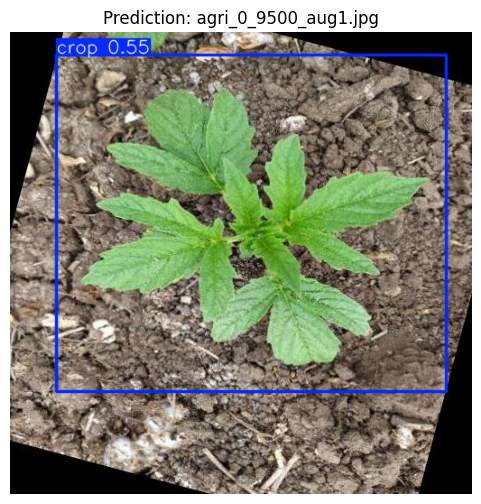


image 1/1 /content/crop_weed_dataset/images/val/agri_0_2345_aug1.jpg: 512x512 3 weeds, 13.6ms
Speed: 1.8ms preprocess, 13.6ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)


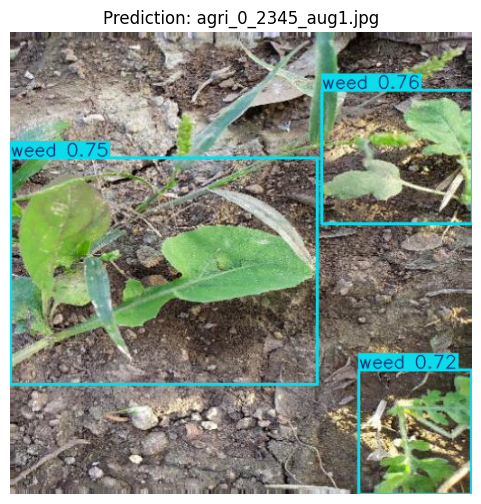


image 1/1 /content/crop_weed_dataset/images/val/agri_0_7204.jpeg: 512x512 1 crop, 11.2ms
Speed: 1.6ms preprocess, 11.2ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)


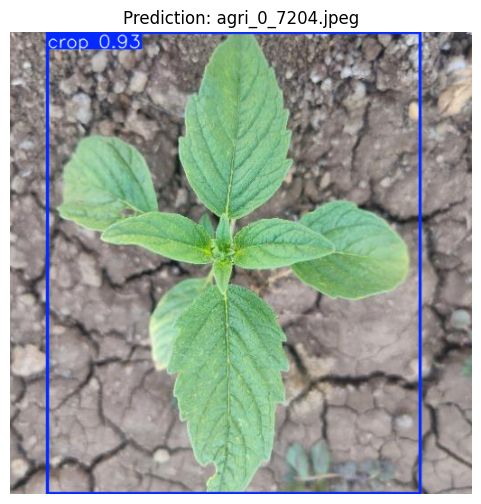

In [40]:
model_path = "runs/detect/crop_weed_detector2/weights/best.pt"

model = YOLO(model_path)

val_img_dir = "/content/crop_weed_dataset/images/val"
sample_images = random.sample(os.listdir(val_img_dir), 3)

for img_name in sample_images:
    img_path = os.path.join(val_img_dir, img_name)


    results = model.predict(source=img_path, conf=0.5)

    for r in results:
        img = r.plot()
        plt.figure(figsize=(6,6))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Prediction: {img_name}")
        plt.show()

# Evaluation & Metrics
Finally, we evaluate model performance:  
- Generate **confusion matrix** to analyze false positives and false negatives.  
- Calculate **precision, recall, and mAP**.  
  


In [49]:
# Run validation
results = model.val(
    data="/content/crop_weed_dataset/data.yaml",
    imgsz=512,
    batch=16
)

# Option 1: Get mean results (precision, recall, mAP50, mAP50-95)
precision, recall, map50, map5095 = results.mean_results()

print("✅ Evaluation Metrics:")
print("Precision:", precision)
print("Recall:", recall)
print("mAP50:", map50)
print("mAP50-95:", map5095)




Ultralytics 8.3.182 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1145.9±477.0 MB/s, size: 66.7 KB)


val: Scanning /content/crop_weed_dataset/labels/val.cache... 780 images, 0 backgrounds, 0 corrupt: 100%|██████████| 780/780 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:07<00:00,  6.43it/s]


                   all        780       1218      0.861      0.821        0.9      0.643
                  crop        406        728      0.823       0.83      0.897      0.676
                  weed        376        490        0.9      0.812      0.904       0.61
Speed: 0.5ms preprocess, 3.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val15
✅ Evaluation Metrics:
Precision: 0.8614003793080838
Recall: 0.8209576138147567
mAP50: 0.9004955527912393
mAP50-95: 0.6432272965815814


Ultralytics 8.3.182 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1026.0±153.3 MB/s, size: 60.5 KB)


val: Scanning /content/crop_weed_dataset/labels/val.cache... 780 images, 0 backgrounds, 0 corrupt: 100%|██████████| 780/780 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:08<00:00,  5.73it/s]


                   all        780       1218      0.861      0.821        0.9      0.643
                  crop        406        728      0.823       0.83      0.897      0.676
                  weed        376        490        0.9      0.812      0.904       0.61
Speed: 0.6ms preprocess, 2.9ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val16


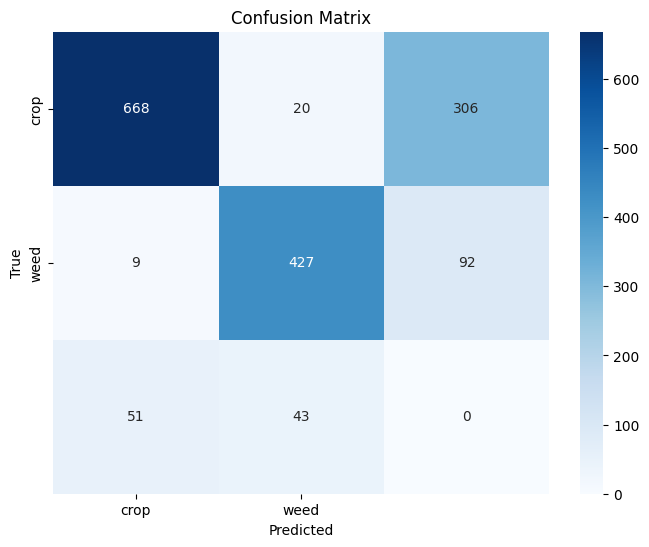

In [50]:
import seaborn as sns

# Run validation with plots
results = model.val(
    data="/content/crop_weed_dataset/data.yaml",
    imgsz=512,
    batch=16,
    plots=True
)

# Get confusion matrix (numpy array)
cm = results.confusion_matrix.matrix  # raw counts
labels = list(results.names.values())  # class names from dataset

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Conclusion
- The YOLOv8 model successfully detected **crops vs weeds**.  
- Key metrics such as **precision, recall, and mAP** show the model’s effectiveness.  
- Improvements can be made with:  
  - More diverse training data.  
  - Hyperparameter tuning.  

This workflow demonstrates how **deep learning + YOLOv8** can aid **precision agriculture** by automating weed detection.  
